In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from data_helper import CorruptedUnlabeledDataset
from data_helper import AddGaussianNoise

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [2]:
class DenoisingAutoencoder(pl.LightningModule):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 3, 2),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, 3, 2),
            nn.LeakyReLU(),

            nn.Conv2d(128, 64, 3, 2),
            nn.LeakyReLU(),
            
            nn.Conv2d(64, 32, 3, 2),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, 2),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(64, 128, 3, 2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 256, 3, 2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 3, 3, 2, output_padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        features = self.encoder(x)
        return features
    
    def training_step(self, batch, batch_idx):
        input_, target_ = batch
        features = self.forward(input_)
        reconstruction = self.decoder(features)
        loss = F.mse_loss(reconstruction, target_)
        
        # add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def prepare_data(self):        
        # All the images are saved in image_folder
        self._image_folder = '../data'

        # The first 106 scenes are unlabeled
        self._unlabeled_scene_index = np.arange(5) # TODO: 106
    
    def train_dataloader(self):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.54, 0.60, 0.63), (0.34, 0.34, 0.34)),
        ])
        noise = AddGaussianNoise(mean=0.0, std=0.25)
        
        unlabeled_trainset = CorruptedUnlabeledDataset(
            image_folder=self._image_folder,
            scene_index=self._unlabeled_scene_index,
            transform=transform,
            noise=noise
        )
        
        return torch.utils.data.DataLoader(
            unlabeled_trainset,
            batch_size=8,  # TODO: 128
            shuffle=True,
            num_workers=2
        )

In [3]:
# model = DenoisingAutoencoder()
# tensor = torch.randn((2, 3, 224, 224), requires_grad=True)
# f = model(tensor)
# f.shape

In [4]:
# r = model.decoder(f)
# r.shape

In [5]:
model = DenoisingAutoencoder()
trainer = Trainer(
    gpus=1,
    max_epochs=10
)
trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name      | Type            | Params
------------------------------------------
0  | encoder   | Sequential      | 394 K 
1  | encoder.0 | Conv2d          | 7 K   
2  | encoder.1 | LeakyReLU       | 0     
3  | encoder.2 | Conv2d          | 295 K 
4  | encoder.3 | LeakyReLU       | 0     
5  | encoder.4 | Conv2d          | 73 K  
6  | encoder.5 | LeakyReLU       | 0     
7  | encoder.6 | Conv2d          | 18 K  
8  | encoder.7 | LeakyReLU       | 0     
9  | decoder   | Sequential      | 394 K 
10 | decoder.0 | ConvTranspose2d | 18 K  
11 | decoder.1 | LeakyReLU       | 0     
12 | decoder.2 | ConvTranspose2d | 73 K  
13 | decoder.3 | LeakyReLU       | 0     
14 | decoder.4 | ConvTranspose2d | 295 K 
15 | decoder.5 | LeakyReLU       | 0     
16 | decoder.6 | ConvTranspose2d | 6 K   
17 | decoder.7 | Tanh            | 0     


C:\ProgramData\Miniconda3\envs\pytorch\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

In [6]:
train_loader = model.train_dataloader()

# [batch_size, 3, H, W]
sample_input, sample_target = iter(train_loader).next()

device = torch.device("cuda")
sample_input = sample_input.to(device)
sample_target = sample_target.to(device)

features = model(sample_input)
sample_output = model.decoder(features)

mean_ = torch.tensor([0.54, 0.60, 0.63]).view(1, 3, 1, 1)
std_ = torch.tensor([0.34, 0.34, 0.34]).view(1, 3, 1, 1)

sample_input = sample_input.cpu() * std_ + mean_
sample_target = sample_target.cpu() * std_ + mean_
sample_output = sample_output.detach().cpu() * std_ + mean_

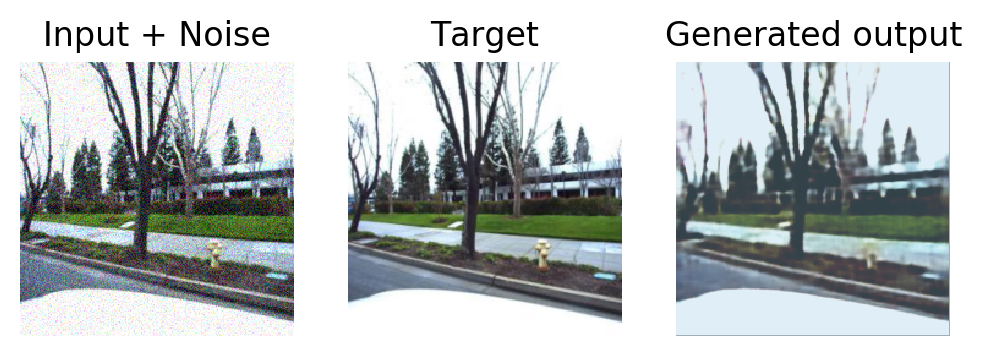

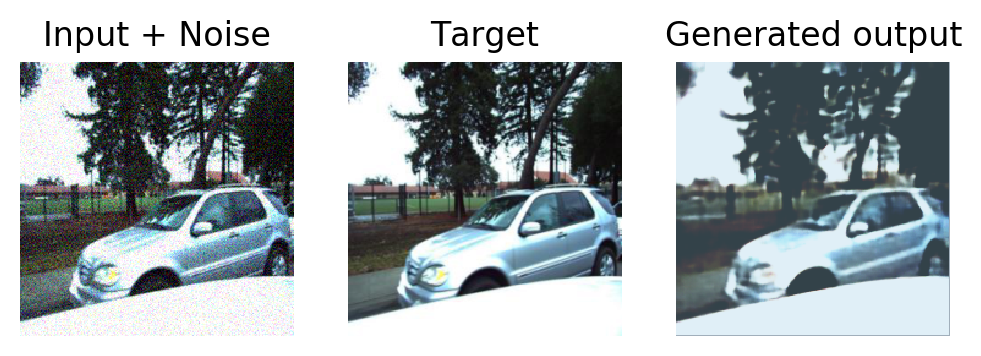

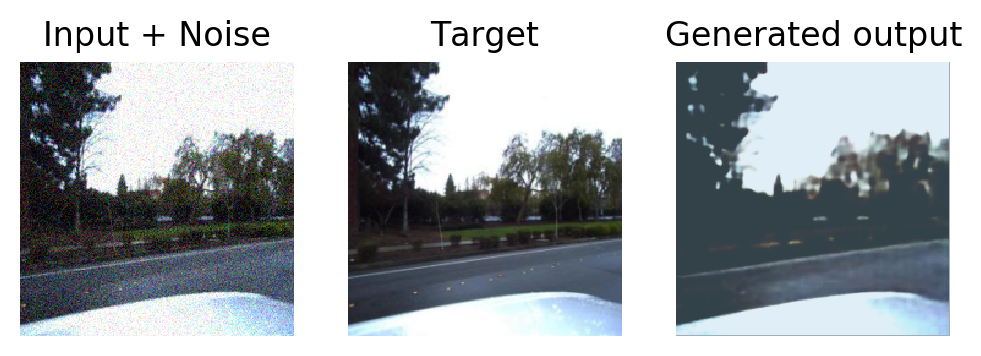

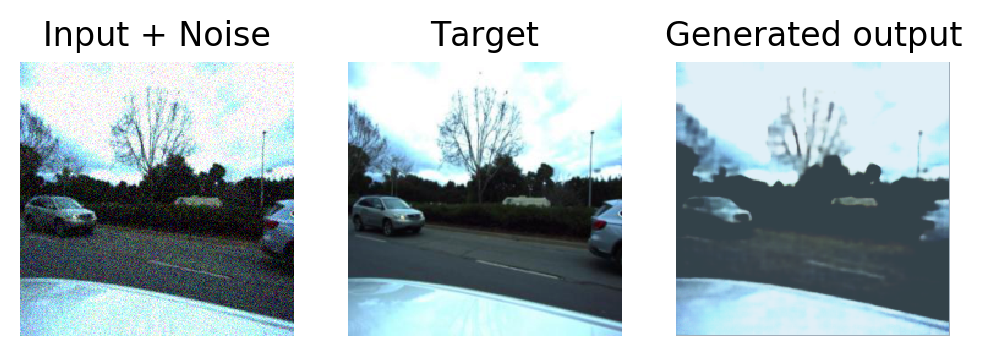

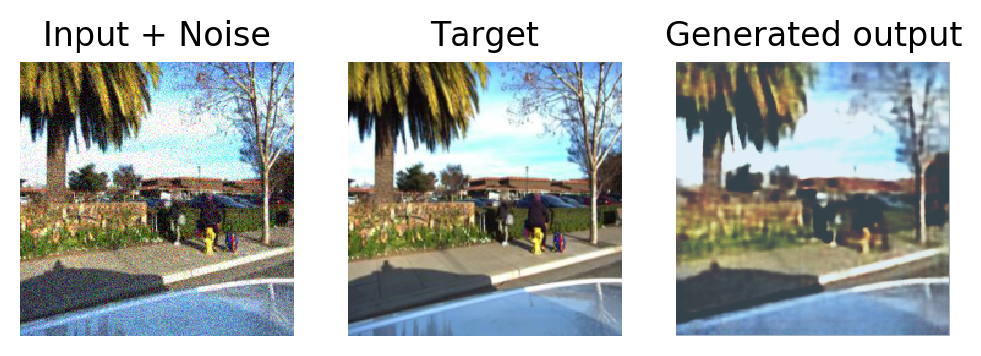

In [13]:
num_samples = 5

sample_idxs = np.random.choice(8, num_samples, False)
for sample_idx in sample_idxs:
    plt.figure(figsize=(6, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_input[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Input + Noise")
    plt.axis('off');

    plt.subplot(1, 3, 2)
    plt.imshow(sample_target[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Target")
    plt.axis('off');

    plt.subplot(1, 3, 3)
    plt.imshow(sample_output[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Generated output")
    plt.axis('off');
    
    plt.show()